In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# fundamental constants
elec_charge = 1.602e-19
boltzmann = 1.381e-23

# parameters
cap_source = 19.8e-18
cap_drain = 48.0e-18
cap_gate = 5.1e-18

tunnel_source = 1.6e6
tunnel_drain = 1.6e6


# calculated quantities
cap_sum = cap_source + cap_drain + cap_gate
charge_energy = (elec_charge ** 2) / cap_sum


In [3]:
def fermi(pot1, pot2, temp):
    return (
        (temp == 0) * (
            1 * (pot1 < pot2) + 0.5 * (pot1 == pot2)
        ) + 

        (temp != 0) * (
            1 / (1 + np.exp((pot1 - pot2) / (boltzmann * temp)))
        )
    )

In [4]:
def dot_potential(N, vol_source, vol_drain, vol_gate):
    cap_charge = vol_source * cap_source + vol_drain * cap_drain + vol_gate * cap_gate

    return charge_energy * (N - 0.5 - (cap_charge / elec_charge))

In [5]:
def rate_into_dot(N, vol_source, vol_drain, vol_gate, temp): # represents R_(N, N-1)
    potential_source = -elec_charge * vol_source
    potential_drain = -elec_charge * vol_drain

    potential_dot = dot_potential(N, vol_source, vol_drain, vol_gate)

    rate_drain = tunnel_drain * fermi(potential_dot, potential_drain, temp)
    rate_source = tunnel_source * fermi(potential_dot, potential_source, temp)

    return rate_drain + rate_source

def rate_out_dot(N, vol_source, vol_drain, vol_gate, temp): # represents R_(N, N+1)
    potential_source = -elec_charge * vol_source
    potential_drain = -elec_charge * vol_drain

    potential_dot = dot_potential(N + 1, vol_source, vol_drain, vol_gate)

    rate_drain = tunnel_drain * (1 - fermi(potential_dot, potential_drain, temp))
    rate_source = tunnel_source * (1 - fermi(potential_dot, potential_source, temp))

    return rate_drain + rate_source

In [6]:
# N_max is the upper limit on the number of electrons the simulation considers for the calculation
# Anything above that is considered too improbable to occur

def generate_plot(N_max, vol_source, vol_drain, vol_gate, temp):
    vol_drain = np.array(vol_drain)
    vol_gate = np.array(vol_gate)
    temp = np.array(temp)

    C = np.zeros(N_max + 1)
    C[-1] = 1

    A = np.zeros(shape=(temp.size, vol_drain.size, vol_gate.size, N_max + 1, N_max + 1))

    index = np.arange(N_max)

    # just below main diagonal terms
    # this (in theory) also fills one term in the bottom row
    # that is not correct, but it gets overriden later
    # after it is used for the calculation of the main diagonal terms
    A[:, :, :, index + 1,index] = rate_into_dot(index + 1, vol_source, np.array([[vol_drain]]).T, np.array([vol_gate]).T, np.array([[[temp]]]).T)


    # just above main diagonal terms
    A[:, :, :, index, index + 1] = rate_out_dot(index, vol_source, np.array([[vol_drain]]).T, np.array([vol_gate]).T, np.array([[[temp]]]).T)

    # main diagonal terms
    A[:, :, :, index, index] = - (A[:, :, :, index + 1, index] + A[:, :, :, index - 1, index])

    # bottom row
    A[:, :, :, -1, :] = 1


    P = np.linalg.inv(A) @ C

    currentIn = -elec_charge * tunnel_drain * np.sum(
        P[:, :, :, index] * fermi(dot_potential(index + 1, vol_source, np.array([[vol_drain]]).T, np.array([vol_gate]).T), -elec_charge * np.array([[vol_drain]]).T, np.array([[[temp]]]).T)
    ,axis = -1)

    currentOut = -elec_charge * tunnel_drain * np.sum(
        P[:, :, :, index + 1] * (1 - fermi(dot_potential(index + 1, vol_source, np.array([[vol_drain]]).T, np.array([vol_gate]).T), -elec_charge * np.array([[vol_drain]]).T, np.array([[[temp]]]).T))
    ,axis = -1)

    return temp, vol_drain, vol_gate, currentIn - currentOut

In [7]:
temp, vol_drain, vol_gate, current = generate_plot(
    N_max=10,
    vol_source=0,
    vol_drain=np.linspace(-2.5e-3, 2.5e-3, 1001),
    vol_gate=np.linspace(0, 0.13, 1301),
    temp=0.25
)

C:\Users\HP\AppData\Local\Temp\ipykernel_2360\197649000.py:8: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp((pot1 - pot2) / (boltzmann * temp)))


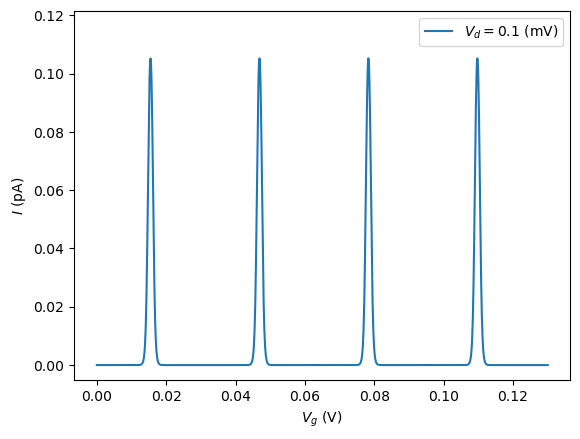

In [8]:
fig, ax = plt.subplots()

ax.plot(vol_gate, current[0, 520] * 1e12, label=f"$V_d = {(vol_drain[520] * 1e3).round(4)}$ (mV)")
ax.legend()

ax.set_xlabel("$V_g$ (V)")
ax.set_ylabel("$I$ (pA)")
ax.set_ybound(upper=ax.get_ybound()[1] * 1.1)

Text(0.5, 1.0, '$I$ (pA)')

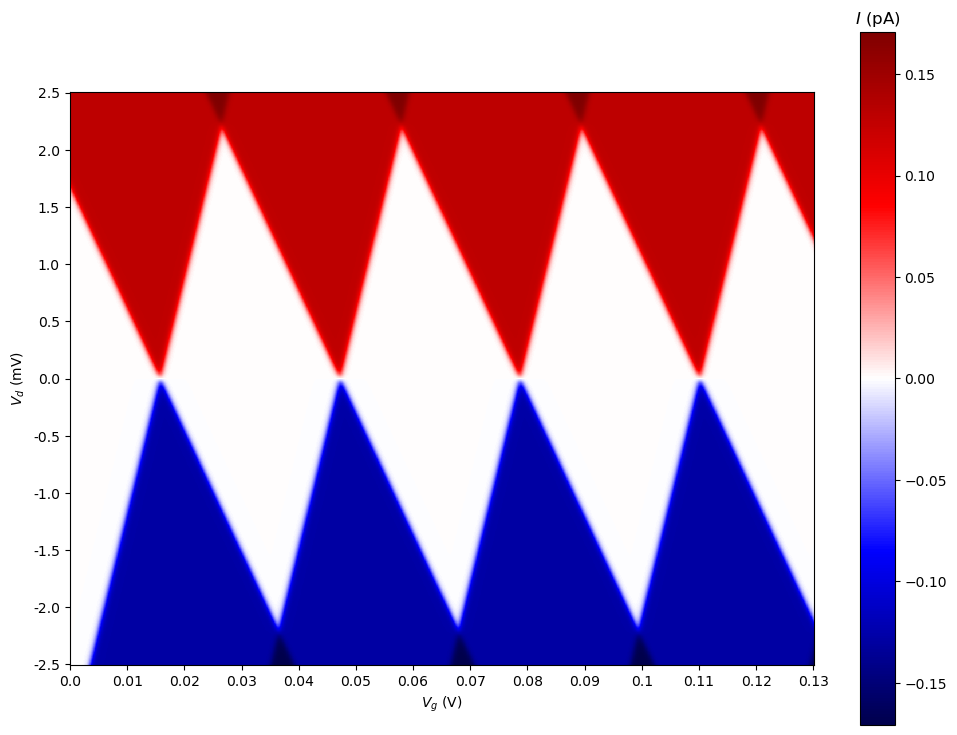

In [9]:
fig, ax = plt.subplots(figsize=(12,9))

pos = ax.imshow(current[0, ::-1] * 1e12, cmap="seismic", interpolation="none")
clb = fig.colorbar(pos, ax=ax)

ax.set_xticks(np.arange(0, 14) * 100, vol_gate[::100].round(2))
ax.set_xlabel("$V_{g}$ (V)")

ax.set_yticks(np.arange(0, 11) * 100, (vol_drain[::-100] * 1e3).round(2))
ax.set_ylabel("$V_{d}$ (mV)")

clb.ax.set_title("$I$ (pA)")

In [10]:
temp, vol_drain, vol_gate, current = generate_plot(
    4,
    0,
    1e-4,
    np.linspace(0., 0.03, 5001),
    temp=[0.05, 0.5, 2]
)

C:\Users\HP\AppData\Local\Temp\ipykernel_2360\197649000.py:8: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp((pot1 - pot2) / (boltzmann * temp)))


Text(0.5, 0, '$V_g$ (V)')

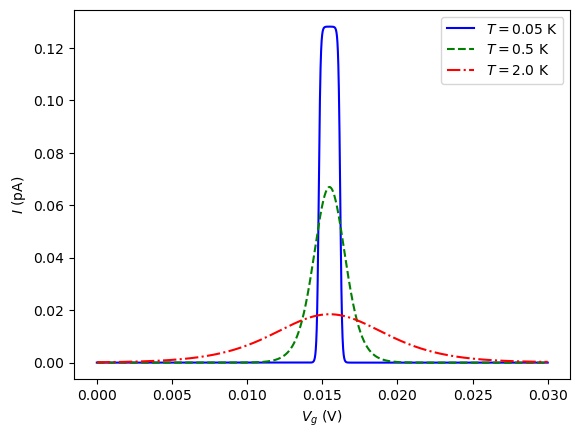

In [11]:
fig, ax = plt.subplots()
ax.plot(vol_gate, current[0, 0] * 1e12, "b", label=f"$T={temp[0]}$ K")
ax.plot(vol_gate, current[1, 0] * 1e12, "g--", label=f"$T={temp[1]}$ K")
ax.plot(vol_gate, current[2, 0] * 1e12, "r-.",label=f"$T={temp[2]}$ K")

ax.legend()
ax.set_ylabel("$I$ (pA)")
ax.set_xlabel("$V_g$ (V)")